In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import date
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('flights_sample_cleaned.csv')

In [3]:
df.head()

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SD_MONTH,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,UA,United Air Lines Inc.,FLL,CLE,1062,4,2015-04-04 11:04:00,2015-04-04 10:59:00,-5.0,2015-04-04 14:00:00,2015-04-04 13:50:00,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00.000000000,-10.0,0
1,DL,Delta Air Lines Inc.,SAN,DTW,1956,12,2015-12-27 11:35:00,2015-12-27 11:29:00,-6.0,2015-12-27 18:59:00,2015-12-27 18:53:00,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00.000000000,-6.0,0
2,WN,Southwest Airlines Co.,MKE,RSW,1183,5,2015-05-21 06:05:00,2015-05-21 05:58:00,-7.0,2015-05-21 10:00:00,2015-05-21 09:50:00,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00.000000000,-10.0,0
3,WN,Southwest Airlines Co.,MDW,CLE,307,7,2015-07-05 22:15:00,2015-07-05 22:13:00,-2.0,2015-07-05 00:20:00,2015-07-05 00:24:00,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,0 days 00:04:00.000000000,4.0,1
4,AA,American Airlines Inc.,PDX,PHX,1009,11,2015-11-06 08:40:00,2015-11-06 08:39:00,-1.0,2015-11-06 12:07:00,2015-11-06 12:03:00,-4.0,10.0,849.0,127.0,1156.0,7.0,144.0,147.0,-1 days +23:56:00.000000000,-4.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236265 entries, 0 to 236264
Data columns (total 22 columns):
AIRLINE                236265 non-null object
ABBR_AIRLINE           236265 non-null object
ORIGIN_AIRPORT         236265 non-null object
DESTINATION_AIRPORT    236265 non-null object
DISTANCE               236265 non-null int64
SD_MONTH               236265 non-null int64
SCHEDULED_DEPARTURE    236265 non-null object
DEPARTURE_TIME         236265 non-null object
DEPARTURE_DELAY        236265 non-null float64
SCHEDULED_ARRIVAL      236265 non-null object
ARRIVAL_TIME           236265 non-null object
ARRIVAL_DELAY          236265 non-null float64
TAXI_OUT               236265 non-null float64
WHEELS_OFF             236265 non-null float64
AIR_TIME               236265 non-null float64
WHEELS_ON              236265 non-null float64
TAXI_IN                236265 non-null float64
ELAPSED_TIME           236265 non-null float64
SCHEDULED_TIME         236265 non-null float64
TOTAL_DE

In [5]:
df['SCHEDULED_DEPARTURE'] = pd.to_datetime(df['SCHEDULED_DEPARTURE'])
df['DEPARTURE_TIME'] = pd.to_datetime(df['DEPARTURE_TIME'])
df['SCHEDULED_ARRIVAL'] = pd.to_datetime(df['SCHEDULED_ARRIVAL'])
df['ARRIVAL_TIME'] = pd.to_datetime(df['ARRIVAL_TIME'])

__Feature Engineering__<br>
Converting to day, month and hour feature from all time stamp features(SCHEDULED_DEPARTURE, DEPARTURE_TIME, SCHEDULED_ARRIVAL, ARRIVAL_TIME)

In [6]:
df['SD_DAY'] = df['SCHEDULED_DEPARTURE'].dt.day
df['SD_HOUR'] = df['SCHEDULED_DEPARTURE'].dt.hour

df['DT_DAY'] = df['DEPARTURE_TIME'].dt.day
df['DT_MONTH'] = df['DEPARTURE_TIME'].dt.month
df['DT_HOUR'] = df['DEPARTURE_TIME'].dt.hour

df['SA_DAY'] = df['SCHEDULED_ARRIVAL'].dt.day
df['SA_MONTH'] = df['SCHEDULED_ARRIVAL'].dt.month
df['SA_HOUR'] = df['SCHEDULED_ARRIVAL'].dt.hour

df['AT_DAY'] = df['ARRIVAL_TIME'].dt.day
df['AT_MONTH'] = df['ARRIVAL_TIME'].dt.month
df['AT_HOUR'] = df['ARRIVAL_TIME'].dt.hour

In [7]:
# df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
#        'DISTANCE','SD_DAY', 'SD_MONTH','SD_HOUR','DT_DAY',
#        'DT_MONTH','DT_HOUR','DEPARTURE_DELAY',
#        'SA_DAY','SA_MONTH','SA_HOUR','AT_DAY','AT_MONTH',
#        'AT_HOUR', 'ARRIVAL_DELAY','TAXI_OUT', 'WHEELS_OFF',
#        'AIR_TIME', 'WHEELS_ON', 'TAXI_IN','ELAPSED_TIME', 
#        'SCHEDULED_TIME', 'TOTAL_DELAY', 'TOTAL_DELAY_MIN',
#        'DELAY']]
# df.head()

In [8]:
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DISTANCE','SD_DAY', 'SD_MONTH','SD_HOUR','DEPARTURE_DELAY',
       'SA_DAY','SA_MONTH','SA_HOUR', 'ARRIVAL_DELAY','TAXI_OUT', 'WHEELS_OFF',
       'AIR_TIME', 'WHEELS_ON', 'TAXI_IN','ELAPSED_TIME', 
       'SCHEDULED_TIME', 'TOTAL_DELAY', 'TOTAL_DELAY_MIN',
       'DELAY']]
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SD_DAY,SD_MONTH,SD_HOUR,DEPARTURE_DELAY,SA_DAY,SA_MONTH,SA_HOUR,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,UA,FLL,CLE,1062,4,4,11,-5.0,4,4,14,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00.000000000,-10.0,0
1,DL,SAN,DTW,1956,27,12,11,-6.0,27,12,18,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00.000000000,-6.0,0
2,WN,MKE,RSW,1183,21,5,6,-7.0,21,5,10,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00.000000000,-10.0,0
3,WN,MDW,CLE,307,5,7,22,-2.0,5,7,0,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,0 days 00:04:00.000000000,4.0,1
4,AA,PDX,PHX,1009,6,11,8,-1.0,6,11,12,-4.0,10.0,849.0,127.0,1156.0,7.0,144.0,147.0,-1 days +23:56:00.000000000,-4.0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236265 entries, 0 to 236264
Data columns (total 22 columns):
AIRLINE                236265 non-null object
ORIGIN_AIRPORT         236265 non-null object
DESTINATION_AIRPORT    236265 non-null object
DISTANCE               236265 non-null int64
SD_DAY                 236265 non-null int64
SD_MONTH               236265 non-null int64
SD_HOUR                236265 non-null int64
DEPARTURE_DELAY        236265 non-null float64
SA_DAY                 236265 non-null int64
SA_MONTH               236265 non-null int64
SA_HOUR                236265 non-null int64
ARRIVAL_DELAY          236265 non-null float64
TAXI_OUT               236265 non-null float64
WHEELS_OFF             236265 non-null float64
AIR_TIME               236265 non-null float64
WHEELS_ON              236265 non-null float64
TAXI_IN                236265 non-null float64
ELAPSED_TIME           236265 non-null float64
SCHEDULED_TIME         236265 non-null float64
TOTAL_DELAY  

Checking the target

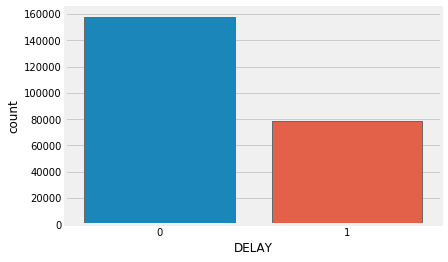

In [10]:
sns.countplot(x=df['DELAY'])

0:1 ratio is only 2:1 respectively.

### Pre-Processing Data
converting categorical features into one hot binary

In [11]:
import category_encoders as ce 

encoder = ce.BinaryEncoder(cols=['AIRLINE'])
df = encoder.fit_transform(df).drop('AIRLINE_0',axis =1)

df.head()

,AIRLINE_1,AIRLINE_2,AIRLINE_3,AIRLINE_4,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SD_DAY,SD_MONTH,SD_HOUR,DEPARTURE_DELAY,SA_DAY,SA_MONTH,SA_HOUR,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,0,0,0,1,FLL,CLE,1062,4,4,11,-5.0,4,4,14,-10.0,13.0,1112.0,149.0,1341.0,9.0,171.0,176.0,-1 days +23:50:00.000000000,-10.0,0
1,0,0,1,0,SAN,DTW,1956,27,12,11,-6.0,27,12,18,-6.0,29.0,1158.0,229.0,1847.0,6.0,264.0,264.0,-1 days +23:54:00.000000000,-6.0,0
2,0,0,1,1,MKE,RSW,1183,21,5,6,-7.0,21,5,10,-10.0,17.0,615.0,151.0,946.0,4.0,172.0,175.0,-1 days +23:50:00.000000000,-10.0,0
3,0,0,1,1,MDW,CLE,307,5,7,22,-2.0,5,7,0,4.0,14.0,2227.0,50.0,17.0,7.0,71.0,65.0,0 days 00:04:00.000000000,4.0,1
4,0,1,0,0,PDX,PHX,1009,6,11,8,-1.0,6,11,12,-4.0,10.0,849.0,127.0,1156.0,7.0,144.0,147.0,-1 days +23:56:00.000000000,-4.0,0


In [12]:
encoder_airport = ce.BinaryEncoder(cols=['ORIGIN_AIRPORT',
                                         'DESTINATION_AIRPORT'])
df = encoder_airport.fit_transform(df).drop(['ORIGIN_AIRPORT_0','DESTINATION_AIRPORT_0'],axis =1)

## Random Forest
There will be 2 Model, First model is to re-evaluate which feature is the most important to the target. And the Second model is to try a real life situation predicting which means only the known factor before flight will be used as the training feature

___Training Model 1___<br>
to re-evaluate which feature is the most important to the target.(advance EDA)

___Train Test Split___

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN'],axis=1)
y  = df['DELAY']

In [15]:
# X =df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN',
#             'AIRLINE_1','AIRLINE_2',
#             'AIRLINE_3','AIRLINE_4',
#            'ORIGIN_AIRPORT_1', 'ORIGIN_AIRPORT_2',
#             'ORIGIN_AIRPORT_3','ORIGIN_AIRPORT_4',
#            'ORIGIN_AIRPORT_5','ORIGIN_AIRPORT_6',
#             'ORIGIN_AIRPORT_7','ORIGIN_AIRPORT_8',
#            'ORIGIN_AIRPORT_9','ORIGIN_AIRPORT_10',
#            'DESTINATION_AIRPORT_1','DESTINATION_AIRPORT_2',
#             'DESTINATION_AIRPORT_3','DESTINATION_AIRPORT_4',
#            'DESTINATION_AIRPORT_5','DESTINATION_AIRPORT_6',
#             'DESTINATION_AIRPORT_7','DESTINATION_AIRPORT_8',
#            'DESTINATION_AIRPORT_9','DESTINATION_AIRPORT_10'
#            ],axis=1)
# y = df['DELAY']

In [16]:
X.dtypes

ORIGIN_AIRPORT_1            int64
ORIGIN_AIRPORT_2            int64
ORIGIN_AIRPORT_3            int64
ORIGIN_AIRPORT_4            int64
ORIGIN_AIRPORT_5            int64
ORIGIN_AIRPORT_6            int64
ORIGIN_AIRPORT_7            int64
ORIGIN_AIRPORT_8            int64
ORIGIN_AIRPORT_9            int64
ORIGIN_AIRPORT_10           int64
DESTINATION_AIRPORT_1       int64
DESTINATION_AIRPORT_2       int64
DESTINATION_AIRPORT_3       int64
DESTINATION_AIRPORT_4       int64
DESTINATION_AIRPORT_5       int64
DESTINATION_AIRPORT_6       int64
DESTINATION_AIRPORT_7       int64
DESTINATION_AIRPORT_8       int64
DESTINATION_AIRPORT_9       int64
DESTINATION_AIRPORT_10      int64
AIRLINE_1                   int64
AIRLINE_2                   int64
AIRLINE_3                   int64
AIRLINE_4                   int64
DISTANCE                    int64
SD_DAY                      int64
SD_MONTH                    int64
SD_HOUR                     int64
DEPARTURE_DELAY           float64
SA_DAY        

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=101)

__Grid Search Param__

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
# from sklearn.model_selection import GridSearchCV
# # scores = ['precision', 'recall']
# parameters = {
#              'class_weight':({0:1,1:5},{0:5,1:1},{0:1,1:1}),
#              'max_depth':(10,20,15,),
#             #'n_estimators':(50,100,150)
#                 }
# rfc = RandomForestClassifier()
# dt = GridSearchCV(rfc,parameters, scoring= 'precision',cv=5)
# dt.fit(X_train,y_train)
# dt.best_estimator_

_GridSearch result based on ROC-AOC Scoring_ <br>
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [77]:
rfc_1 = RandomForestClassifier(n_estimators =100) #class_weight={0:1,1:0},max_depth=14

In [78]:
rfc_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

___Predictions and Evaluation Model 1___ 

In [79]:
from sklearn.metrics import classification_report,confusion_matrix,matthews_corrcoef, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc,f1_score

In [80]:
predict = rfc_1.predict(X_test)
predictProb = rfc_1.predict_proba(X_test)

In [81]:
predict_tr = rfc_1.predict(X_train)
predictProb_tr = rfc_1.predict_proba(X_train)

Train Data Result

In [82]:
print(classification_report(y_train,predict_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110332
           1       1.00      1.00      1.00     55053

   micro avg       1.00      1.00      1.00    165385
   macro avg       1.00      1.00      1.00    165385
weighted avg       1.00      1.00      1.00    165385



In [83]:
print('ROC AUC :', roc_auc_score(y_train, predictProb_tr[:,1]))
print('Accuracy :',accuracy_score(y_train, predict_tr))
print('Matthews Corr_coef :',matthews_corrcoef(y_train, predict_tr))

ROC AUC : 1.0
Accuracy : 1.0
Matthews Corr_coef : 1.0


Test Data Result

In [84]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79     47261
           1       0.46      0.11      0.17     23619

   micro avg       0.66      0.66      0.66     70880
   macro avg       0.57      0.52      0.48     70880
weighted avg       0.60      0.66      0.58     70880



In [85]:
print('ROC AUC :', roc_auc_score(y_test, predictProb[:,1]))
print('Accuracy :',accuracy_score(y_test, predict))
print('Matthews Corr_coef :',matthews_corrcoef(y_test, predict))

ROC AUC : 0.5764158180271727
Accuracy : 0.660426072234763
Matthews Corr_coef : 0.07658974482130157


Feature of importance

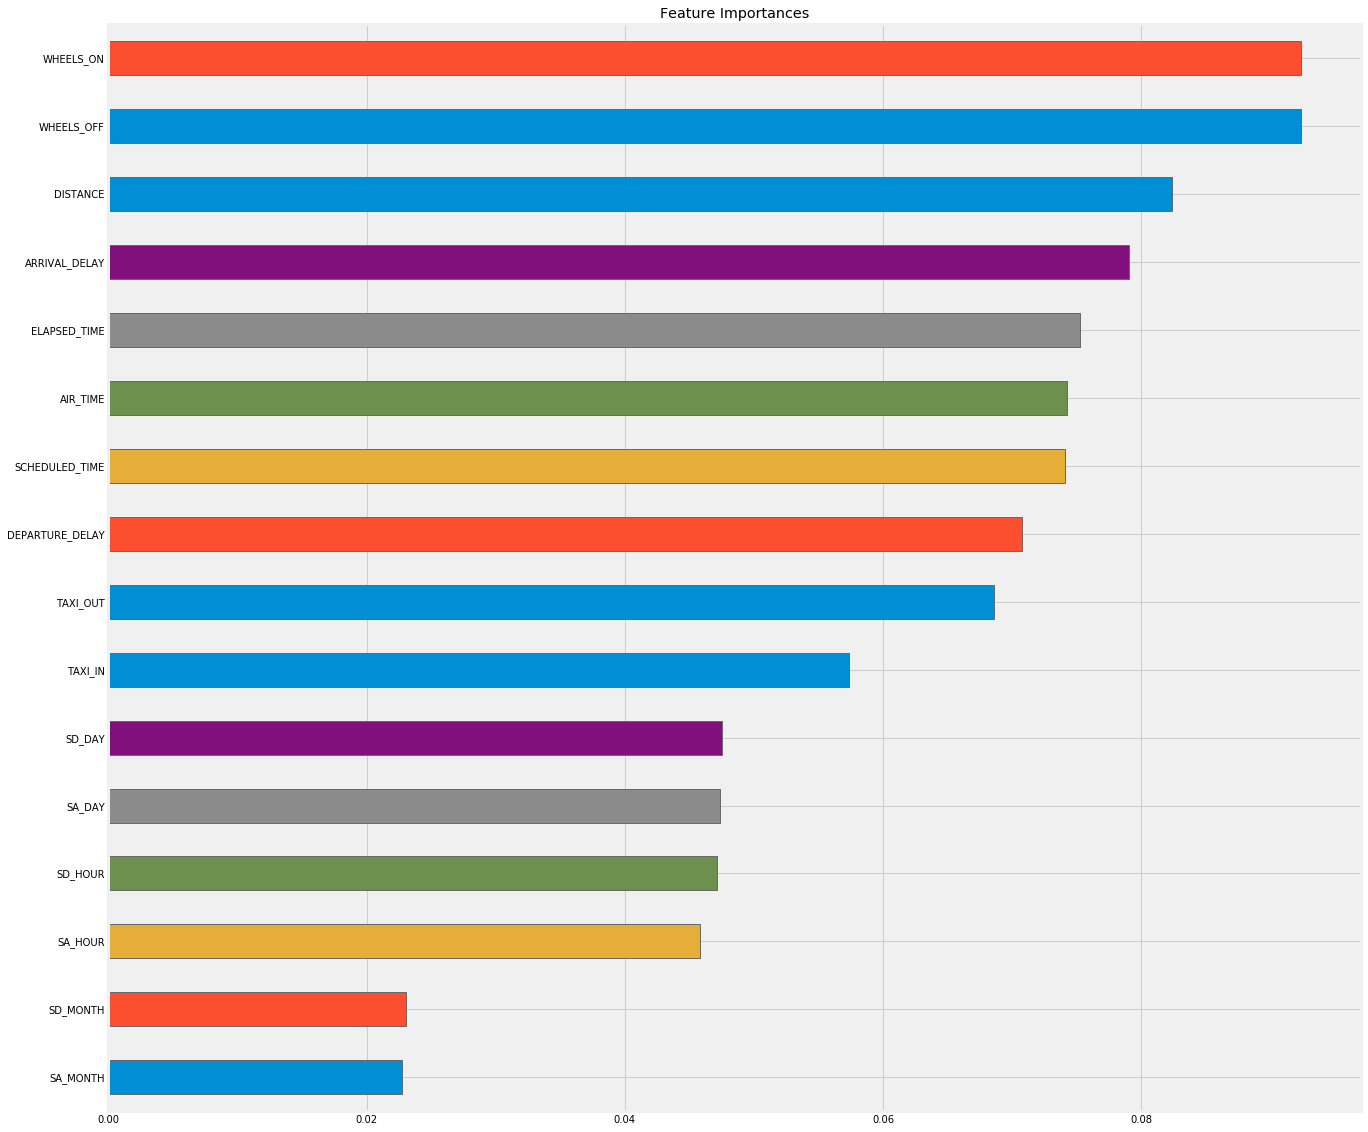

In [86]:
plt.figure(figsize =(20,20))
coef1 = pd.Series(rfc_1.feature_importances_, X_train.columns).sort_values(ascending = True)
coef1.plot(kind='barh', title='Feature Importances')

___Training Model 2___<br>
to mimic real life situation where only the known factor in the tickets is train.

___Train Test Split___

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X =df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN',
            'DEPARTURE_DELAY','ARRIVAL_DELAY',
            'TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN',
            'ELAPSED_TIME'
            ,'AIRLINE_1','AIRLINE_2',
            'AIRLINE_3','AIRLINE_4',
           'ORIGIN_AIRPORT_1', 'ORIGIN_AIRPORT_2',
            'ORIGIN_AIRPORT_3','ORIGIN_AIRPORT_4',
           'ORIGIN_AIRPORT_5','ORIGIN_AIRPORT_6',
            'ORIGIN_AIRPORT_7','ORIGIN_AIRPORT_8',
           'ORIGIN_AIRPORT_9','ORIGIN_AIRPORT_10',
           'DESTINATION_AIRPORT_1','DESTINATION_AIRPORT_2',
            'DESTINATION_AIRPORT_3','DESTINATION_AIRPORT_4',
           'DESTINATION_AIRPORT_5','DESTINATION_AIRPORT_6',
            'DESTINATION_AIRPORT_7','DESTINATION_AIRPORT_8',
           'DESTINATION_AIRPORT_9','DESTINATION_AIRPORT_10'
           ],axis=1)
y = df['DELAY']

In [89]:
X.columns

Index(['DISTANCE', 'SD_DAY', 'SD_MONTH', 'SD_HOUR', 'SA_DAY', 'SA_MONTH',
       'SA_HOUR', 'AIR_TIME', 'SCHEDULED_TIME'],
      dtype='object')

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=101)

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [150]:
rfc_2 = RandomForestClassifier(n_estimators= 100,max_features=5,max_depth = 15,class_weight={0:1,1:2})

In [151]:
rfc_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2},
            criterion='gini', max_depth=15, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

___Predictions and Evaluation Model 2___ 

In [152]:
from sklearn.metrics import classification_report,confusion_matrix,matthews_corrcoef, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc,f1_score

In [153]:
predict = rfc_2.predict(X_test)
predictProb = rfc_2.predict_proba(X_test)

In [154]:
predict_tr = rfc_2.predict(X_train)
predictProb_tr = rfc_2.predict_proba(X_train)

Train Data Result

In [155]:
print(classification_report(y_train,predict_tr))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82    110332
           1       0.64      0.73      0.68     55053

   micro avg       0.77      0.77      0.77    165385
   macro avg       0.75      0.76      0.75    165385
weighted avg       0.78      0.77      0.78    165385



In [156]:
print('ROC AUC :', roc_auc_score(y_train, predictProb_tr[:,1]))
print('Accuracy :',accuracy_score(y_train, predict_tr))
print('Matthews Corr_coef :',matthews_corrcoef(y_train, predict_tr))

ROC AUC : 0.8580354680302571
Accuracy : 0.7727423889711884
Matthews Corr_coef : 0.5099020987851507


Test Data Result

In [157]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71     47261
           1       0.42      0.43      0.42     23619

   micro avg       0.61      0.61      0.61     70880
   macro avg       0.56      0.57      0.56     70880
weighted avg       0.61      0.61      0.61     70880



In [158]:
print('ROC AUC :', roc_auc_score(y_test, predictProb[:,1]))
print('Accuracy :',accuracy_score(y_test, predict))
print('Matthews Corr_coef :',matthews_corrcoef(y_test, predict))

ROC AUC : 0.5917298616922513
Accuracy : 0.6102990970654627
Matthews Corr_coef : 0.12994029878245958


Feature of importance

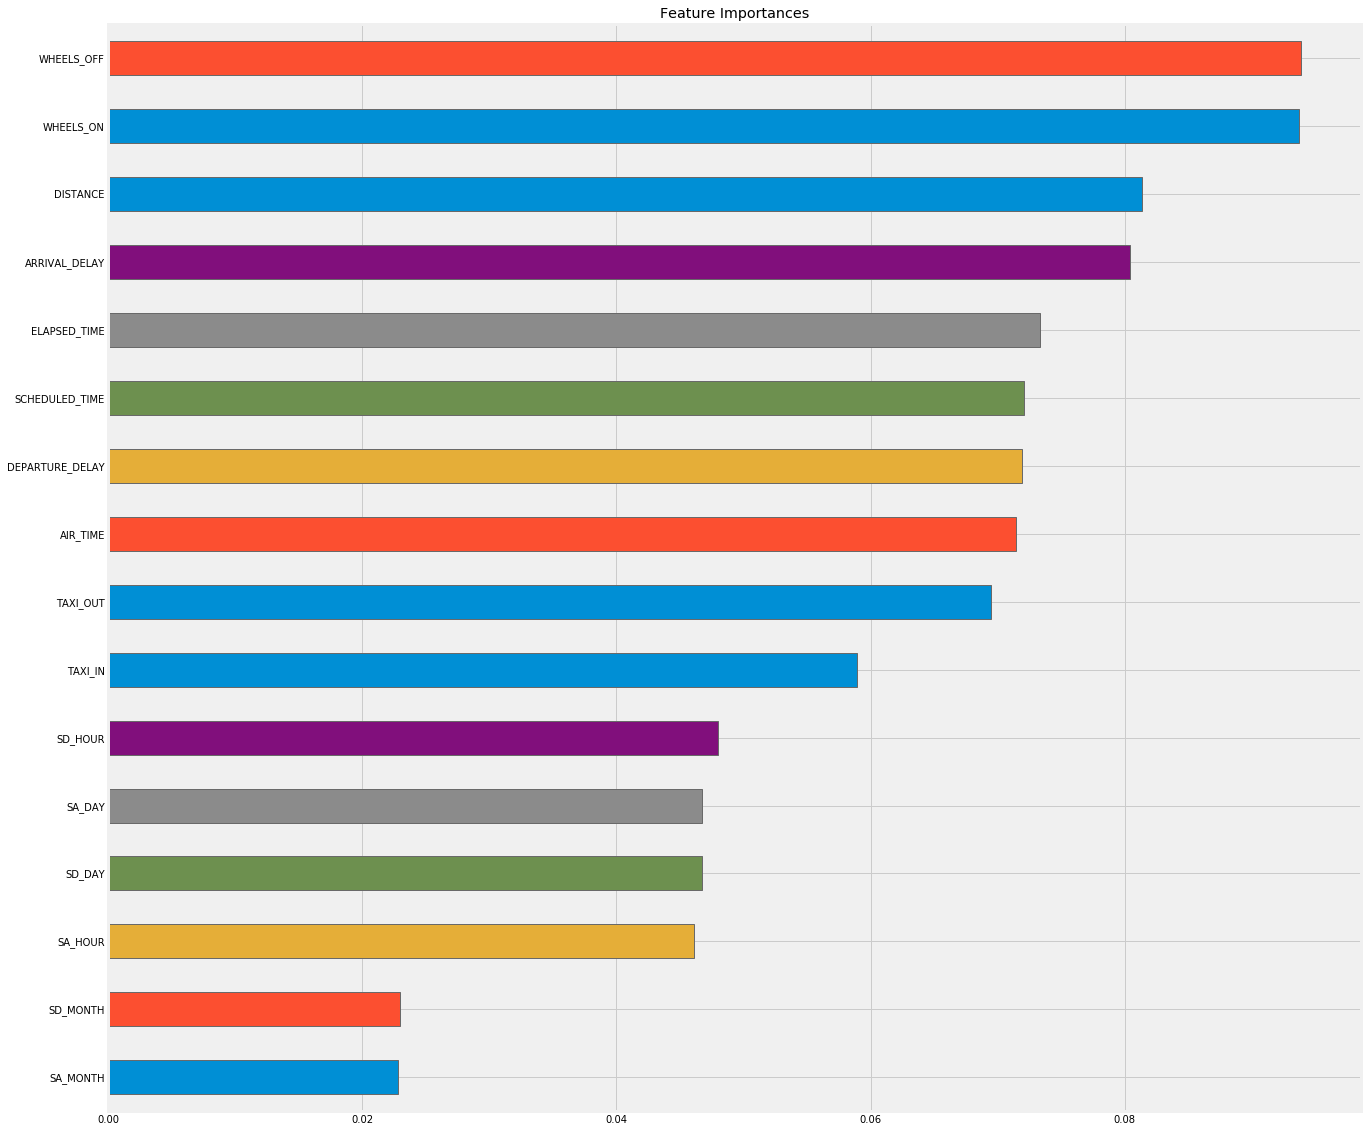

In [141]:
plt.figure(figsize =(20,20))
coef1 = pd.Series(rfc_2.feature_importances_, X_train.columns).sort_values(ascending = True)
coef1.plot(kind='barh', title='Feature Importances')

### Using K-Folds Cross-Validation 
to check how valid is the model

In [102]:
# data = df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN'],axis=1)
# target  = df['DELAY']

In [103]:
data =df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN',
            'DEPARTURE_DELAY','ARRIVAL_DELAY',
            'TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN',
            'ELAPSED_TIME'
            ,'AIRLINE_1','AIRLINE_2',
            'AIRLINE_3','AIRLINE_4',
           'ORIGIN_AIRPORT_1', 'ORIGIN_AIRPORT_2',
            'ORIGIN_AIRPORT_3','ORIGIN_AIRPORT_4',
           'ORIGIN_AIRPORT_5','ORIGIN_AIRPORT_6',
            'ORIGIN_AIRPORT_7','ORIGIN_AIRPORT_8',
           'ORIGIN_AIRPORT_9','ORIGIN_AIRPORT_10',
           'DESTINATION_AIRPORT_1','DESTINATION_AIRPORT_2',
            'DESTINATION_AIRPORT_3','DESTINATION_AIRPORT_4',
           'DESTINATION_AIRPORT_5','DESTINATION_AIRPORT_6',
            'DESTINATION_AIRPORT_7','DESTINATION_AIRPORT_8',
           'DESTINATION_AIRPORT_9','DESTINATION_AIRPORT_10'
           ],axis=1)
target = df['DELAY']

In [104]:
data.shape

(236265, 9)

In [105]:
from sklearn.model_selection import KFold

K = 5
kf = KFold(n_splits=K,shuffle = True,random_state=42)

In [106]:
def calc_error(X, y, model):
    predictions = model.predict(X)
    predicProba = model.predict_proba(X)
    matt = matthews_corrcoef(y, predictions)
    f1 = f1_score(y, predictions, average='macro')
    report = classification_report(y, predictions)
    roc_auc = roc_auc_score(y, predicProba[:,1])
    accuracy = accuracy_score(y,predictions)
    con = pd.DataFrame(data=confusion_matrix(y,predictions),columns=['P No','P Yes'],index=['A No','A Yes'])
        
    return {
            'report':report,
            'matthew':matt,
            'f1':f1,
            'roc':roc_auc,
            'accuracy':accuracy,
            'confusion':con
            }

def calc_metrics(X_train,y_train,X_test,y_test, model):
    model.fit(X_train,y_train)
    train_error = calc_error(X_train,y_train, model)
    validation_error = calc_error(X_test,y_test, model)
    
    return train_error, validation_error

def value_in_kfold(data,scoring_type):
    a = []
    for i in range(K):
        a.append(data[i][scoring_type])
    return a

In [107]:
from sklearn.linear_model import LogisticRegression

In [108]:
train_errors = []
validation_errors = []

for train_index, val_index in kf.split(data, target):
    
    # Split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]
    
    print(len(X_val),(len(X_train) + len(X_val)))
    
    # Instantite model
    model = rfc_2
    
    # Calculate Errors
    train_error, val_error = calc_metrics(X_train,y_train,X_val, y_val,model)
    
    train_errors.append(train_error)
    validation_errors.append(val_error)

47253 236265
47253 236265
47253 236265
47253 236265
47253 236265


In [109]:
acc = value_in_kfold(train_errors,'accuracy')
matt = value_in_kfold(train_errors,'matthew')
f1 = value_in_kfold(train_errors,'f1')
roc = value_in_kfold(train_errors,'roc')
con = value_in_kfold(train_errors,'confusion')
report = value_in_kfold(train_errors,'report')

In [110]:
acc_v = value_in_kfold(validation_errors,'accuracy')
matt_v = value_in_kfold(validation_errors,'matthew')
f1_v = value_in_kfold(validation_errors,'f1')
roc_v = value_in_kfold(validation_errors,'roc')
con_v = value_in_kfold(validation_errors,'confusion')
report_v = value_in_kfold(validation_errors,'report')

In [111]:
data_set = {'Train Acc':acc,
            'Test Acc':acc_v,
            'Train ROC AUC':roc,
            'Test ROC AUC':roc_v,
            'Train F1 Score':f1,
            'Test F1 Score':f1_v,
            'Train Matthews Corr Coef':matt,
            'Test Matthews Corr Coef':matt_v}

In [112]:
dfcc_result = pd.DataFrame(data_set)
dfcc_result

,Train Acc,Test Acc,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Matthews Corr Coef,Test Matthews Corr Coef
0,0.999995,0.641589,1.0,0.565370,0.999994,0.511902,0.999988,0.075186
1,0.999989,0.641674,1.0,0.569284,0.999988,0.510443,0.999976,0.078433
2,0.999995,0.644192,1.0,0.566864,0.999994,0.515979,0.999988,0.083437
3,1.000000,0.645123,1.0,0.567343,1.000000,0.515402,1.000000,0.080832
4,0.999995,0.643790,1.0,0.568079,0.999994,0.514669,0.999988,0.077111


In [113]:
for item in data_set.keys():
    print('Average ' + str(item) +': ', np.mean(data_set[item]))

Average Train Acc:  0.9999947093306245
Average Test Acc:  0.6432734429560028
Average Train ROC AUC:  0.9999999992058747
Average Test ROC AUC:  0.5673878761576038
Average Train F1 Score:  0.9999940419181185
Average Test F1 Score:  0.5136789514311519
Average Train Matthews Corr Coef:  0.9999880839356958
Average Test Matthews Corr Coef:  0.07899971404156093


Report for Train dataset

In [114]:
for n,item in enumerate(report):
    print(item)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126099
           1       1.00      1.00      1.00     62913

   micro avg       1.00      1.00      1.00    189012
   macro avg       1.00      1.00      1.00    189012
weighted avg       1.00      1.00      1.00    189012

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126275
           1       1.00      1.00      1.00     62737

   micro avg       1.00      1.00      1.00    189012
   macro avg       1.00      1.00      1.00    189012
weighted avg       1.00      1.00      1.00    189012

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126097
           1       1.00      1.00      1.00     62915

   micro avg       1.00      1.00      1.00    189012
   macro avg       1.00      1.00      1.00    189012
weighted avg       1.00      1.00      1.00    189012

              preci

Result for test dataset

In [115]:
for n,item in enumerate(report_v):
    print(item)

              precision    recall  f1-score   support

           0       0.68      0.87      0.76     31494
           1       0.42      0.19      0.26     15759

   micro avg       0.64      0.64      0.64     47253
   macro avg       0.55      0.53      0.51     47253
weighted avg       0.59      0.64      0.60     47253

              precision    recall  f1-score   support

           0       0.68      0.87      0.76     31318
           1       0.43      0.18      0.26     15935

   micro avg       0.64      0.64      0.64     47253
   macro avg       0.55      0.53      0.51     47253
weighted avg       0.59      0.64      0.59     47253

              precision    recall  f1-score   support

           0       0.68      0.87      0.77     31496
           1       0.43      0.19      0.27     15757

   micro avg       0.64      0.64      0.64     47253
   macro avg       0.55      0.53      0.52     47253
weighted avg       0.60      0.64      0.60     47253

              preci

## Gradient Boosting 
comparing gradient boosting with random forest

___Training Model 1___<br>
to re-evaluate which feature is the most important to the target.(advance EDA)

___Train Test Split___

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
X =df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN',
            'AIRLINE_1','AIRLINE_2',
            'AIRLINE_3','AIRLINE_4',
           'ORIGIN_AIRPORT_1', 'ORIGIN_AIRPORT_2',
            'ORIGIN_AIRPORT_3','ORIGIN_AIRPORT_4',
           'ORIGIN_AIRPORT_5','ORIGIN_AIRPORT_6',
            'ORIGIN_AIRPORT_7','ORIGIN_AIRPORT_8',
           'ORIGIN_AIRPORT_9','ORIGIN_AIRPORT_10',
           'DESTINATION_AIRPORT_1','DESTINATION_AIRPORT_2',
            'DESTINATION_AIRPORT_3','DESTINATION_AIRPORT_4',
           'DESTINATION_AIRPORT_5','DESTINATION_AIRPORT_6',
            'DESTINATION_AIRPORT_7','DESTINATION_AIRPORT_8',
           'DESTINATION_AIRPORT_9','DESTINATION_AIRPORT_10'
           ],axis=1)
y = df['DELAY']

In [118]:
X.dtypes

DISTANCE             int64
SD_DAY               int64
SD_MONTH             int64
SD_HOUR              int64
DEPARTURE_DELAY    float64
SA_DAY               int64
SA_MONTH             int64
SA_HOUR              int64
ARRIVAL_DELAY      float64
TAXI_OUT           float64
WHEELS_OFF         float64
AIR_TIME           float64
WHEELS_ON          float64
TAXI_IN            float64
ELAPSED_TIME       float64
SCHEDULED_TIME     float64
dtype: object

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

In [120]:
from xgboost import XGBClassifier

In [121]:
xgb_1 = XGBClassifier(learning_rate=0.1)

In [122]:
xgb_1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

___Predictions and Evaluation Model 1___ 

In [123]:
from sklearn.metrics import classification_report,confusion_matrix,matthews_corrcoef, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc,f1_score

In [124]:
predict = xgb_1.predict(X_test)
predictProb = xgb_1.predict_proba(X_test)

In [125]:
predict_tr = xgb_1.predict(X_train)
predictProb_tr = xgb_1.predict_proba(X_train)

Train Data Result

In [126]:
print(classification_report(y_train,predict_tr))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80    110332
           1       0.65      0.01      0.02     55053

   micro avg       0.67      0.67      0.67    165385
   macro avg       0.66      0.50      0.41    165385
weighted avg       0.66      0.67      0.54    165385



In [127]:
print('ROC AUC :', roc_auc_score(y_train, predictProb_tr[:,1]))
print('Accuracy :',accuracy_score(y_train, predict_tr))
print('Matthews Corr_coef :',matthews_corrcoef(y_train, predict_tr))

ROC AUC : 0.6065169429046776
Accuracy : 0.6688817002751156
Matthews Corr_coef : 0.05168408954499516


Test Data Result

In [128]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80     47261
           1       0.60      0.01      0.02     23619

   micro avg       0.67      0.67      0.67     70880
   macro avg       0.63      0.50      0.41     70880
weighted avg       0.65      0.67      0.54     70880



In [129]:
print('ROC AUC :', roc_auc_score(y_test, predictProb[:,1]))
print('Accuracy :',accuracy_score(y_test, predict))
print('Matthews Corr_coef :',matthews_corrcoef(y_test, predict))

ROC AUC : 0.5929259767727135
Accuracy : 0.6678752821670428
Matthews Corr_coef : 0.042180824466056796


Feature of importance

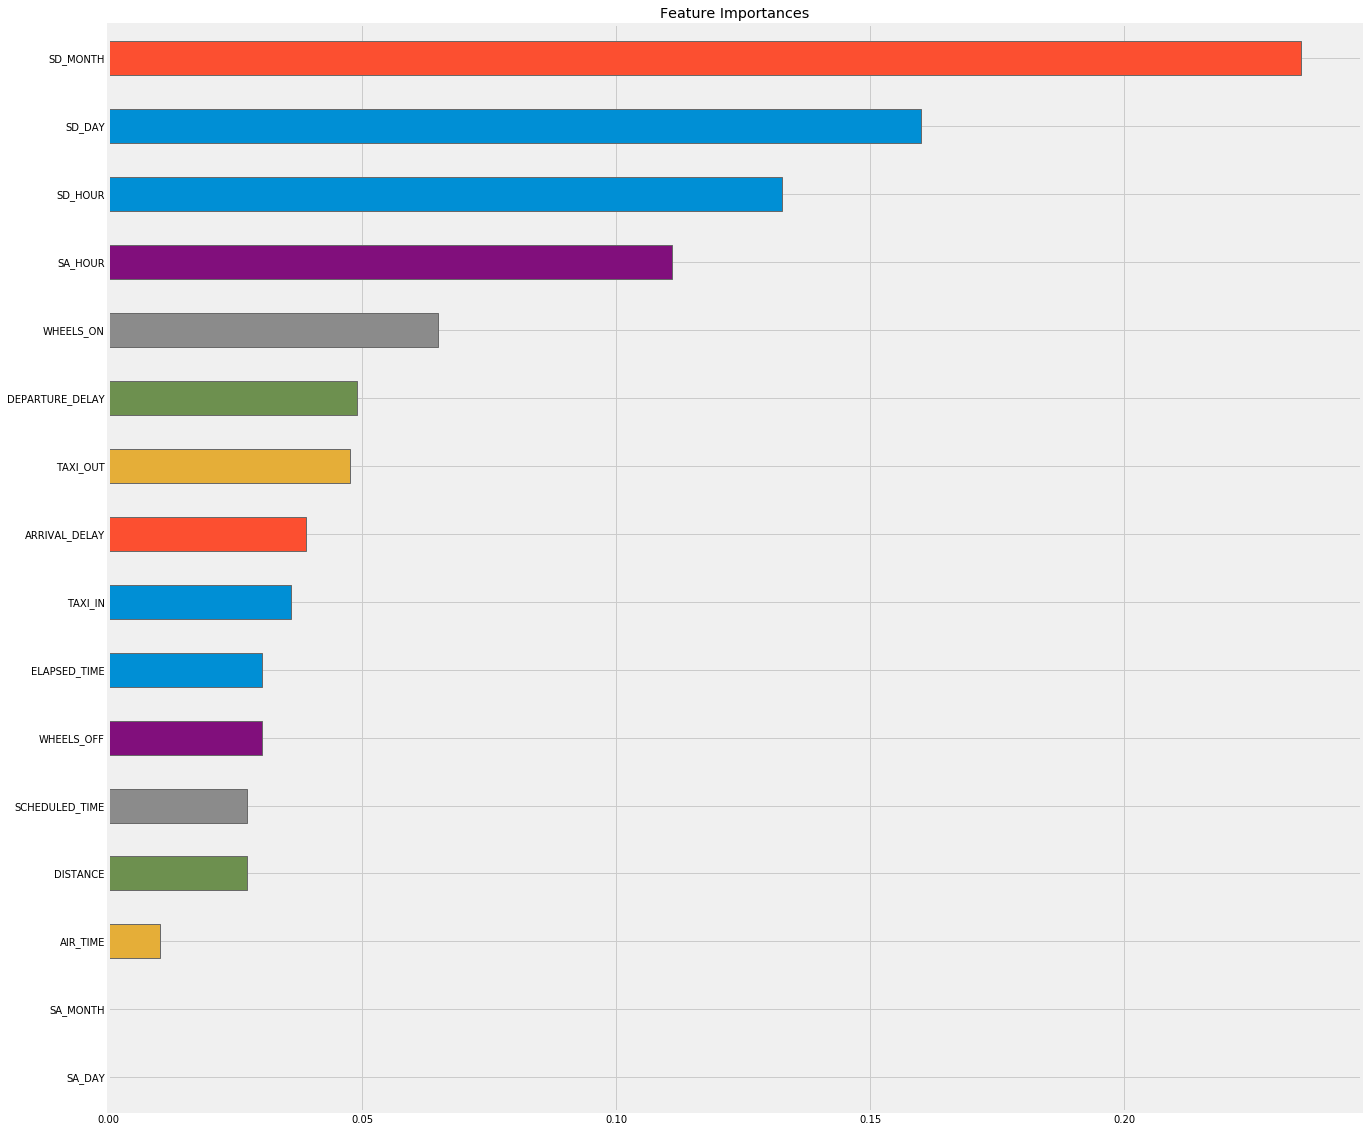

In [130]:
plt.figure(figsize =(20,20))
coef1 = pd.Series(xgb_1.feature_importances_, X_train.columns).sort_values(ascending = True)
coef1.plot(kind='barh', title='Feature Importances')

XGBoost shows worse performance than random forest(RFC) thus for this data I will only use the RFC model. *note that only model 2 will be exported to .sav file since model one was only for EDA purposes.

In [131]:
import pickle
filename = 'flight_rfc_model.sav';
pickle.dump(rfc_2, open(filename, 'wb'))